In [ ]:
"""
Purpose: To be able to determine where a limb object should 
be cut if it has a crossover
(especially in application to double soma splitting)



"""

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from os import sys
sys.path.append("/meshAfterParty/")

In [39]:
from importlib import reload

import neuron_utils as nru

import neuron

import neuron_visualizations as nviz

import time

import datajoint_utils as du

import numpy as np

In [5]:
minnie,schema = du.configure_minnie_vm()

INFO - 2020-12-23 03:00:10,724 - settings - Setting enable_python_native_blobs to True
INFO - 2020-12-23 03:00:10,955 - settings - Setting enable_python_native_blobs to True


# Picking a Neuron to Analyze

In [7]:
minnie.DecompositionMultiSoma() & "n_somas>1"

segment_id segment id unique within each Segmentation,decimation_version,decimation_ratio ratio of remaining mesh vertices/faces (which ones depends on what metric the decimation technique uses),decomposition,n_vertices number of vertices,n_faces number of faces,n_error_limbs the number of limbs that are touching multiple somas or 1 soma in multiple places,n_same_soma_multi_touching_limbs number of limbs that touch the same soma multiple times,n_multi_soma_touching_limbs number of limbs that touch multiple somas,n_somas number of soma meshes detected,n_limbs,n_branches,max_limb_n_branches,skeletal_length,max_limb_skeletal_length,median_branch_length gives information on average skeletal length to next branch point,width_median median width from mesh center without spines removed,width_no_spine_median median width from mesh center with spines removed,width_90_perc 90th percentile for width without spines removed,width_no_spine_90_perc 90th percentile for width with spines removed,n_spines,spine_density n_spines/ skeletal_length,spines_per_branch,skeletal_length_eligible the skeletal length for all branches searched for spines,n_spine_eligible_branches the number of branches that were checked for spines because passed width threshold,spine_density_eligible n_spines/skeletal_length_eligible,spines_per_branch_eligible n_spines/n_spine_eligible_branches,total_spine_volume the sum of all spine volume,spine_volume_median median of the spine volume for those spines with able to calculate volume,spine_volume_density total_spine_volume/skeletal_length,spine_volume_density_eligible total_spine_volume/skeletal_length_eligible,spine_volume_per_branch_eligible total_spine_volume/n_spine_eligible_branches,run_time the amount of time to run (seconds)
864691134988402042,0,0.25,=BLOB=,939750,1891203,1,0,1,2,11,260,129,9926423.076049272,3837120.3077007174,19498.793,99.274,99.274,489.663,475.385,3464,0.00034896759622890023,13.323076923076924,6602403.65,127,nan,nan,158333783964.6377,22787252.596668243,15950.739027703696,23981.233556454503,1246722708.382974,2086.0103
864691134988472442,0,0.25,=BLOB=,760380,1540479,2,2,1,2,13,363,156,8953235.669383887,4544614.922947489,14310.191,84.402,84.402,468.087,373.666,2735,0.0003054761542078572,7.534435261707989,3995011.885,125,nan,nan,141833693783.9872,29636743.193003334,15841.612911966098,35502.696329021615,1134669550.2718978,2332.3713
864691135012400886,0,0.25,=BLOB=,802480,1644474,1,1,1,2,16,269,96,7875858.169030763,2360988.8843716034,18603.612,255.953,230.461,454.247,405.981,3810,0.00048375680697013807,14.1635687732342,6797185.75,192,nan,nan,237479305298.37152,35811946.28458786,30152.816391765566,34937.88665380691,1236871381.7623518,10256.3515
864691135081658359,0,0.25,=BLOB=,1607079,3235599,2,2,1,2,16,566,222,17383118.66936267,6172738.160942182,16478.245,104.692,104.692,487.313,428.015,6643,0.000382152370144497,11.736749116607774,10212426.203,268,nan,nan,279434899541.12573,20787632.10667928,16075.072882843688,27362.24419022377,1042667535.6012154,24169.9911
864691135103989069,0,0.25,=BLOB=,1245458,2502307,1,0,1,2,16,331,79,11756897.144402271,2465284.4707440175,20465.579,321.001,265.448,491.55,445.508,5678,0.0004829505549177511,17.154078549848943,8429003.434,209,nan,nan,303415329029.90393,27481356.392502148,25807.432463110978,35996.583867319365,1451747985.789014,7967.3317
864691135207768697,0,0.25,=BLOB=,1067465,2149606,2,1,1,2,17,260,85,8946738.643342396,2846658.3866573754,23190.431,358.987,309.871,566.021,515.849,4621,0.0005165010608014865,17.773076923076925,7806528.505,214,nan,nan,294025101920.43787,27074805.833293915,32863.942229857465,37664.0015766442,1373949074.3945694,19055.2293
864691135210033344,0,0.25,=BLOB=,1093479,2238756,2,1,1,2,11,367,186,11431382.161309652,5830748.601730345,16936.767,188.963,185.938,437.996,402.889,4500,0.0003936531852841539,12.26158038147139,7261235.173,202,nan,nan,276047625630.4887,31026774.45333735,24148.228248793228,38016.621009182774,1366572404.1113303,18653.8569
86469

In [8]:
segment_id = 864691134988402042

In [9]:
neuron_obj = (minnie.DecompositionMultiSoma() & dict(segment_id=segment_id)).fetch1("decomposition")

Decompressing Neuron in minimal output mode...please wait


In [12]:
nviz.visualize_neuron(neuron_obj,
                     visualize_type=["mesh","skeleton"],
                     limb_branch_dict="all")


 Working on visualization type: mesh

 Working on visualization type: skeleton


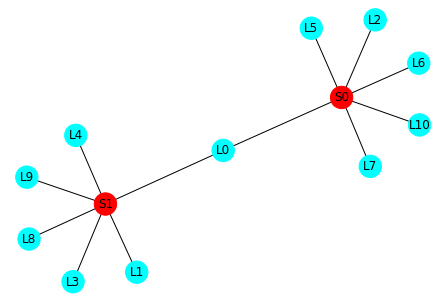

In [13]:
nviz.plot_soma_limb_concept_network(neuron_obj)

# Finging all the high degree cross over nodes in the error limb

In [15]:
mult_soma_touch_limbs = nru.multi_soma_touching_limbs(neuron_obj)
curr_limb_idx = int(mult_soma_touch_limbs[0])


nviz.visualize_neuron(neuron_obj,
                     visualize_type=["mesh","skeleton"],
                     limb_branch_dict={f"L{curr_limb_idx}":"all"})


 Working on visualization type: mesh

 Working on visualization type: skeleton


In [17]:
import skeleton_utils as sk
import networkx_utils as xu

In [38]:
curr_limb = neuron_obj[curr_limb_idx]
curr_limb_name = f"L{curr_limb_idx}"

limb_sk_graph = sk.convert_skeleton_to_graph(curr_limb.skeleton)
high_degree_nodes = xu.get_nodes_greater_or_equal_degree_k(limb_sk_graph,4)

high_degree_coordinates = xu.get_node_attributes(limb_sk_graph,node_list = high_degree_nodes)
high_degree_coordinates

array([[1339708.81694217,  809556.2212723 ,  761526.3403248 ],
       [1367182.94830553,  783034.86541071,  755420.31426427],
       [1367227.6857212 ,  773050.38797514,  747281.48712281],
       [1367884.89268873,  771898.36315752,  746446.84437338],
       [1395195.70949673,  919307.14383089,  789227.77809425],
       [1460260.90346243,  735376.82351291,  639255.00530794]])

In [32]:
# Visualizing the locations of high degree coordinates

nviz.visualize_neuron(neuron_obj,
                     visualize_type=["mesh","skeleton"],
                     limb_branch_dict={f"L{curr_limb_idx}":"all"},
                      mesh_color="green",
                      skeleton_color="blue",
                     scatters=[high_degree_coordinates],
                      scatters_colors="red",
                     scatter_size=0.3)


 Working on visualization type: mesh

 Working on visualization type: skeleton


In [37]:
# finding the branches for the high degree coordinates
sk_branches = [br.skeleton for br in curr_limb]

branches_per_high_degree_coordinate = [sk.find_branch_skeleton_with_specific_coordinate(sk_branches,coord)
                                       for coord in high_degree_coordinates]

branches_per_high_degree_coordinate

[[64, 65, 69, 98],
 [10, 11, 57, 78],
 [11, 12, 59, 60],
 [58, 59, 77, 81],
 [35, 36, 106, 110],
 [76, 77, 99, 109]]

In [42]:
# visualizing the crossover branches
concat_branches = np.concatenate(branches_per_high_degree_coordinate)
print(f"concat_branches = {concat_branches}")
nviz.visualize_neuron(neuron_obj,
                      visualize_type=["mesh","skeleton"],
                     limb_branch_dict={curr_limb_name:"all"},
                     mesh_color={curr_limb_name:{k:"red" for k in concat_branches}},
                      mesh_fill_color="green",
                      skeleton_color={curr_limb_name:{k:"black" for k in concat_branches}},
                      skeleton_fill_color="green")

concat_branches = [ 64  65  69  98  10  11  57  78  11  12  59  60  58  59  77  81  35  36
 106 110  76  77  99 109]

 Working on visualization type: mesh

 Working on visualization type: skeleton


In [34]:
sk.find_branch_skeleton_with_specific_coordinate?

In [33]:
dir(sk)

['KDTree',
 'Mesh',
 'Path',
 'Skeleton',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'add_and_smooth_segment_to_branch',
 'align_skeletons_at_connectivity',
 'angle',
 'calcification',
 'calcification_param',
 'calculate_skeleton_distance',
 'calculate_skeleton_paths_on_mesh',
 'calculate_skeleton_segment_distances',
 'change_basis_matrix',
 'check_correspondence_branches_have_2_endpoints',
 'check_skeleton_connected_component',
 'check_skeleton_one_component',
 'clean_skeleton',
 'clean_skeleton_with_decompose',
 'clean_skeleton_with_soma_verts',
 'cm',
 'collapse_soma_skeleton',
 'combine_close_branch_points',
 'combine_meshes',
 'compare_endpoints',
 'compare_skeletons_ordered',
 'compute_segments',
 'convert_branch_graph_to_skeleton',
 'convert_graph_to_skeleton',
 'convert_nodes_edges_to_skeleton',
 'convert_skeleton_to_graph',
 'convert_skeleton_to_graph_old',
 'convert_skeleton_to_nodes_edges',
 'copy',
 'cr

# Spliiting Algorithm

In [ ]:
"""
Purpose: To determine the connectivity that should be at the location
of a crossover (the cuts that should be made and the new connectivity)

Pseudocode: 
1) Get all the branches that correspond to the coordinate
2) For each branch
- get the boundary cosine angle between the other branches
- if within a threshold then add edge
3) Ge the subgraph of all these branches:
- find what edges you have to cut
4) Return the cuts/subgraph

"""


In [72]:
import copy
limb_obj = copy.deepcopy(curr_limb)
coordinate = high_degree_coordinates[0]
verbose = True

In [73]:
#1) Get all the branches that correspond to the coordinate
sk_branches = [br.skeleton for br in limb_obj]

coordinate_branches = np.sort(sk.find_branch_skeleton_with_specific_coordinate(sk_branches,coordinate))

curr_colors = ["red","aqua","purple","green"]
nviz.plot_objects(meshes=[limb_obj[k].mesh for k in coordinate_branches],
                 meshes_colors=curr_colors,
                 skeletons=[limb_obj[k].skeleton for k in coordinate_branches],
                 skeletons_colors=curr_colors)

In [74]:
coordinate_branches

array([64, 65, 69, 98])

In [75]:
# 2) For each branch
# - get the boundary cosine angle between the other branches
# - if within a threshold then add edge

match_threshold = 40
match_branches = []

for br1_idx in coordinate_branches:
    for br2_idx in coordinate_branches:
        if br1_idx>=br2_idx:
            continue
            
        # - get the boundary cosine angle between the other branches
        curr_angle = nru.find_parent_child_skeleton_angle(limb_obj,
                                                         child_node=br1_idx,
                                                         parent_node=br2_idx,
                                                         offset=2500,
                                                         check_upstream_network_connectivity=False)
        if verbose:
            print(f"Angle between {br1_idx} and {br2_idx} = {curr_angle} ")
            
        # - if within a threshold then add edge
        if curr_angle <= match_threshold:
            match_branches.append([br1_idx,br2_idx])

Angle between 64 and 65 = 83.94 
Angle between 64 and 69 = 128.61 
Angle between 64 and 98 = 57.0 
Angle between 65 and 69 = 6.28 
Angle between 65 and 98 = 173.33 
Angle between 69 and 98 = 5.62 


In [76]:
match_branches

[[65, 69], [69, 98]]

In [77]:
nviz.plot_objects(meshes=[limb_obj[k].mesh for k in match_branches[0]],
                 meshes_colors=curr_colors,
                 skeletons=[limb_obj[k].skeleton for k in match_branches[0]],
                 skeletons_colors=curr_colors)

In [78]:
import numpy_utils as nu

([array([64, 65]), array([65, 98])], [array([69, 98])])

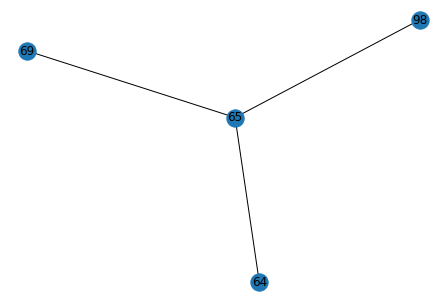

In [71]:

# find what cuts and connections need to make
import networkx as nx
limb_subgraph = limb_obj.concept_network.subgraph(coordinate_branches)
nx.draw(limb_subgraph,with_labels=True)

sorted_edges = np.sort(limb_subgraph.edges(),axis=1)
sorted_confirmed_edges = np.sort(match_branches,axis=1)
sorted_confirmed_edges

edges_to_delete = []

for ed in sorted_edges:
    if len(nu.matching_rows_old(sorted_confirmed_edges,ed))==0:
        edges_to_delete.append(ed)

edges_to_create = []

for ed in sorted_confirmed_edges:
    if len(nu.matching_rows_old(sorted_edges,ed))==0:
        edges_to_create.append(ed)
edges_to_delete,edges_to_create



In [81]:
#actually creating the new sugraph
limb_obj.concept_network.remove_edges_from(edges_to_delete)
limb_obj.concept_network.add_edges_from(edges_to_create)
limb_obj.concept_network

# Creating the Function

In [91]:
import error_detection as ed
ed.resolving_crossovers(limb_obj = copy.deepcopy(curr_limb),
                     coordinate = high_degree_coordinates[0],
                    match_threshold = 40,
                    verbose = False,
                     return_new_edges = True,
                    return_subgraph=True,
                    plot_intermediates=False)

[[array([64, 65]), array([65, 69]), array([65, 98])],
 [array([69, 98])],

In [100]:
np.argmax([-np.inf,3])


1